In [49]:
import pandas as pd
from modules import Agent,Model
from DCAStrategy import DCAAgent
from LSStrategy import LSSAgent
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


Start Trading

In [50]:
symbol = "FPT"

In [51]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')

In [52]:
df.tail

<bound method NDFrame.tail of             Date     Close      Open      High       Low
0     2014-01-14    9429.7    9410.6    9563.9    9391.4
1     2014-01-15    9583.0    9506.4    9870.5    9487.2
2     2014-01-16    9678.9    9774.7    9774.7    9583.0
3     2014-01-17    9870.5    9774.7   10062.2    9678.9
4     2014-01-20    9966.4    9870.5   10253.9    9870.5
...          ...       ...       ...       ...       ...
2591  2024-06-10  144000.0  143500.0  145000.0  143000.0
2592  2024-06-11  146500.0  144300.0  146500.0  143100.0
2593  2024-06-12  132000.0  127900.0  132700.0  127800.0
2594  2024-06-13  130000.0  133700.0  133800.0  130000.0
2595  2024-06-14  131000.0  130000.0  132500.0  129000.0

[2596 rows x 5 columns]>

Trade without LSTM

In [53]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 500000
skip = 1
from_date ="2024-05-06"
to_date = "2024-06-14"
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [54]:
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [55]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[2.45750744e-301 1.00000000e+000 0.00000000e+000]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]


In [56]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

In [57]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,all_bought,all_sold,gain
0,data not enough to trade,0,127600.0,500000.0,2024-06-18 18:33:36.863498,2024-05-06,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,131300.0,500000.0,2024-06-18 18:33:36.863498,2024-05-07,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:36.863498,2024-05-08,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,130300.0,500000.0,2024-06-18 18:33:36.864498,2024-05-09,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:36.864498,2024-05-10,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,129700.0,500000.0,2024-06-18 18:33:36.864498,2024-05-13,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,130500.0,500000.0,2024-06-18 18:33:36.864498,2024-05-14,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,134100.0,500000.0,2024-06-18 18:33:36.864498,2024-05-15,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,135400.0,500000.0,2024-06-18 18:33:36.865498,2024-05-16,NaN,NaN,NaN,NaN,NaN,NaN
9,do nothing,0,134500.0,500000.0,2024-06-18 18:33:36.866879,2024-05-17,500000.0,NaN,NaN,NaN,NaN,NaN


In [58]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

-0.3969686033922772
-3.1199999999999997


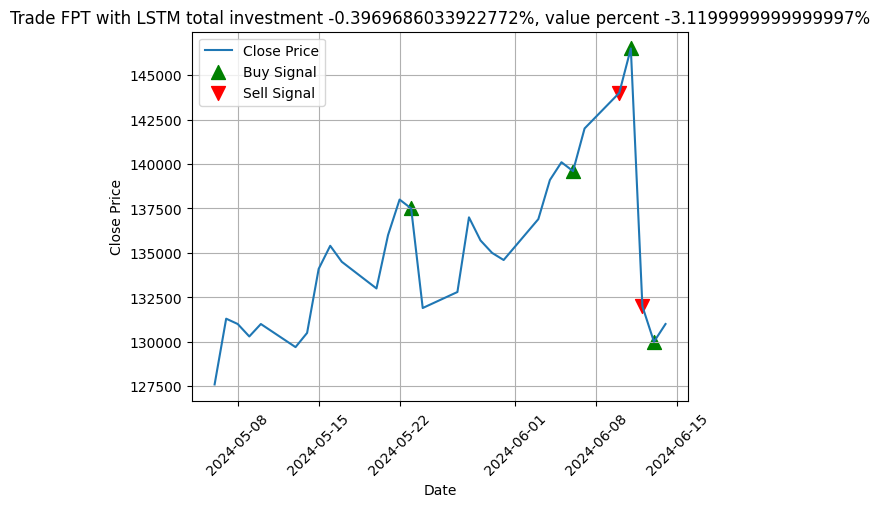

In [59]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

With LSTM

In [60]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = np.max(parameters[0]) * 3
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}prediction_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}prediction_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [61]:
agent2 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [62]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent2.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[2.19886594e-12 0.00000000e+00 1.00000000e+00]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1.00000000e+00 0.00000000e+00 3.08041815e-62]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]


In [63]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [64]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,all_bought,all_sold,gain
0,data not enough to trade,0,127600.0,500000.0,2024-06-18 18:33:37.461684,2024-05-06,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,131300.0,500000.0,2024-06-18 18:33:37.461684,2024-05-07,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:37.461684,2024-05-08,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,130300.0,500000.0,2024-06-18 18:33:37.461684,2024-05-09,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:37.461684,2024-05-10,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,129700.0,500000.0,2024-06-18 18:33:37.461684,2024-05-13,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,130500.0,500000.0,2024-06-18 18:33:37.461684,2024-05-14,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,134100.0,500000.0,2024-06-18 18:33:37.461684,2024-05-15,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,135400.0,500000.0,2024-06-18 18:33:37.461684,2024-05-16,NaN,NaN,NaN,NaN,NaN,NaN
9,do nothing,0,134500.0,500000.0,2024-06-18 18:33:37.461684,2024-05-17,500000.0,NaN,NaN,NaN,NaN,NaN


In [65]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

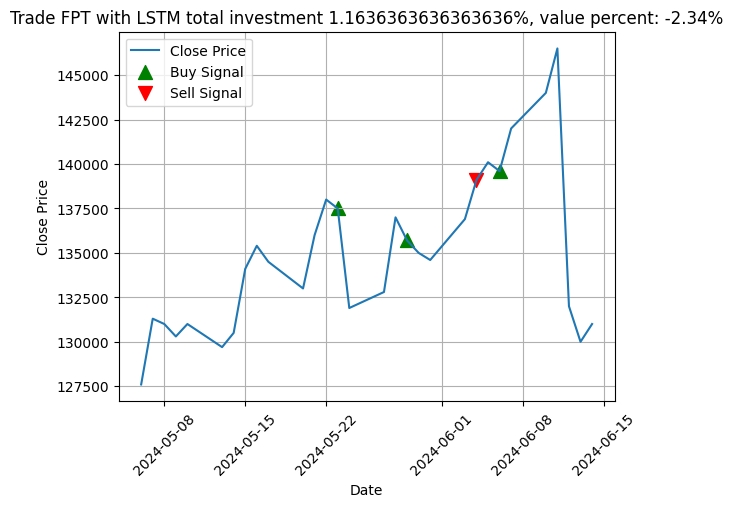

1.1636363636363636
-2.34


In [66]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA without LSTM

In [67]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
# initial_money = np.max(parameters[0]) * 5
initial_money =  500000
minmax = pickle.load(open(f"checkpoint/{symbol}_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [68]:
agent3 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [69]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent3.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]


In [70]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [71]:
result

,status,action,close,balance,timestamp,date,total,investment,average_investment,all_bought,all_sold,total_investment,total_gain,total_sold
0,data not enough to trade,0,127600.0,500000.0,2024-06-18 18:33:38.173894,2024-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,131300.0,500000.0,2024-06-18 18:33:38.173894,2024-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:38.173894,2024-05-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,130300.0,500000.0,2024-06-18 18:33:38.173894,2024-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:38.175451,2024-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,129700.0,500000.0,2024-06-18 18:33:38.175451,2024-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,130500.0,500000.0,2024-06-18 18:33:38.176009,2024-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,134100.0,500000.0,2024-06-18 18:33:38.176009,2024-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,135400.0,500000.0,2024-06-18 18:33:38.176009,2024-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,do nothing,0,134500.0,500000.0,2024-06-18 18:33:38.178227,2024-05-17,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

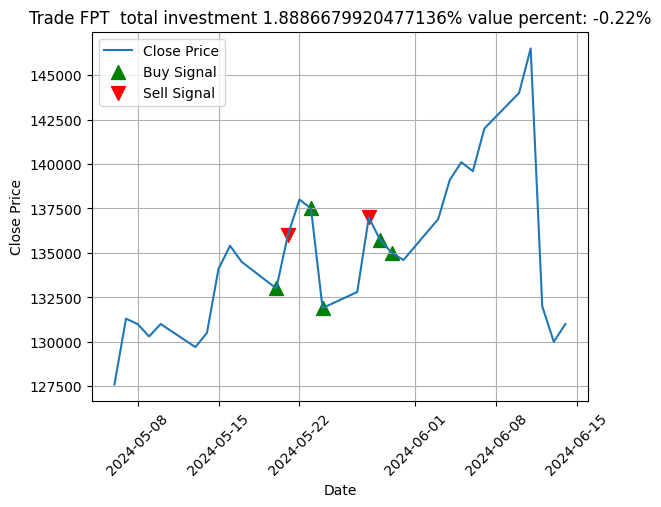

1.8886679920477136
-0.22


In [73]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM

In [74]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [75]:
agent4 = DCAAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [76]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent4.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0.00000000e+00 5.12865531e-13 1.00000000e+00]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]


In [77]:
trade_results

[{'status': 'data not enough to trade',
  'action': 0,
  'close': 127600.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:38.751080',
  'date': '2024-05-06'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 131300.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:38.752276',
  'date': '2024-05-07'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 131000.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:38.752276',
  'date': '2024-05-08'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 130300.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:38.752276',
  'date': '2024-05-09'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 131000.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:38.752276',
  'date': '2024-05-10'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 129700.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:38.752276',
  'date': '2024-05-13'}

In [78]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [79]:
result

,status,action,close,balance,timestamp,date,total,investment,average_investment,all_bought,all_sold,total_investment,total_gain,total_sold
0,data not enough to trade,0,127600.0,500000.0,2024-06-18 18:33:38.751080,2024-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data not enough to trade,0,131300.0,500000.0,2024-06-18 18:33:38.752276,2024-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:38.752276,2024-05-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data not enough to trade,0,130300.0,500000.0,2024-06-18 18:33:38.752276,2024-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:38.752276,2024-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,data not enough to trade,0,129700.0,500000.0,2024-06-18 18:33:38.752276,2024-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,data not enough to trade,0,130500.0,500000.0,2024-06-18 18:33:38.753539,2024-05-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,data not enough to trade,0,134100.0,500000.0,2024-06-18 18:33:38.753539,2024-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,data not enough to trade,0,135400.0,500000.0,2024-06-18 18:33:38.754074,2024-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,do nothing,0,134500.0,500000.0,2024-06-18 18:33:38.755321,2024-05-17,500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

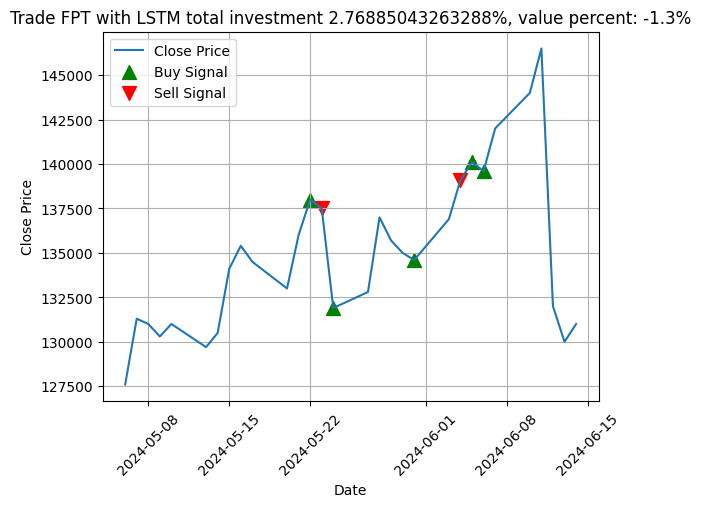

2.76885043263288
-1.3


In [81]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

LSS WITHOUT LSTM


In [82]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()


c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [83]:
df.tail

<bound method NDFrame.tail of            Date     Close  pct_change  log_change            7ma  \
21   2014-02-21   11116.3    0.017538    0.017386   10959.628500   
22   2014-02-24   11403.8    0.025863    0.025534   11070.820133   
23   2014-02-25   11787.2    0.033620    0.033068   11250.094983   
24   2014-02-26   12362.1    0.048773    0.047621   11528.305603   
25   2014-02-27   12074.6   -0.023257   -0.023531   11664.956329   
...         ...       ...         ...         ...            ...   
2591 2024-06-10  144000.0    0.014085    0.013986  140166.881130   
2592 2024-06-11  146500.0    0.017361    0.017212  141750.160847   
2593 2024-06-12  132000.0   -0.098976   -0.104224  139312.620635   
2594 2024-06-13  130000.0   -0.015152   -0.015267  136984.465477   
2595 2024-06-14  131000.0    0.007692    0.007663  135488.349107   

               14ma           21ma        7macd       14macd       7rsi  ...  \
21     10806.684047   10715.604409  -204.008519  -198.569202  57.140727  

In [84]:
agent5 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [85]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent5.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[8.699158e-312 0.000000e+000 1.000000e+000]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]


In [86]:
trade_results

[{'status': 'data not enough to trade',
  'action': 0,
  'close': 127600.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:39.269335',
  'date': '2024-05-06'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 131300.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:39.269335',
  'date': '2024-05-07'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 131000.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:39.269335',
  'date': '2024-05-08'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 130300.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:39.269335',
  'date': '2024-05-09'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 131000.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:39.269335',
  'date': '2024-05-10'},
 {'status': 'data not enough to trade',
  'action': 0,
  'close': 129700.0,
  'balance': 500000,
  'timestamp': '2024-06-18 18:33:39.269335',
  'date': '2024-05-13'}

In [87]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [88]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

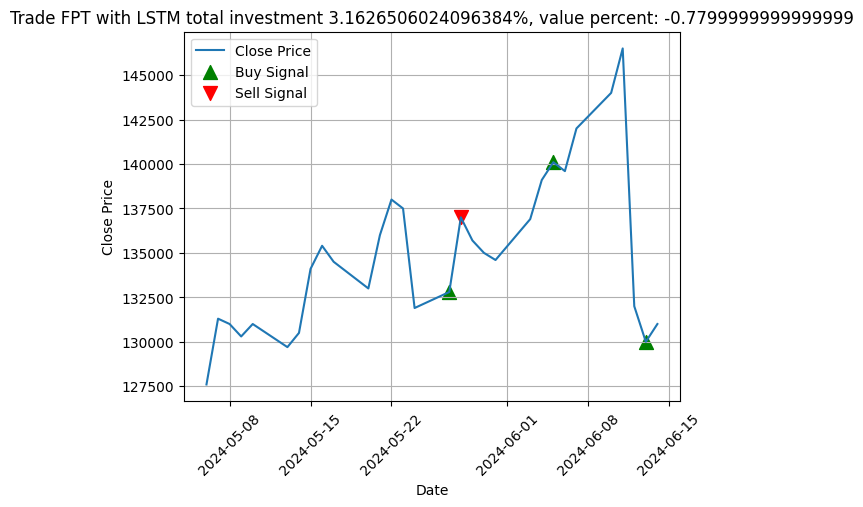

3.1626506024096384
-0.7799999999999999


In [89]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

LSS WITH LSTM

In [90]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
initial_money = 500000
minmax = pickle.load(open(f"checkpoint/{symbol}Prediction_LSSscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}Prediction_LSSmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [91]:
agent6 = LSSAgent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)

In [92]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent6.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]


In [93]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
# total_gain = result['gain'].sum()
# total_investment = result['investment'].sum()

In [94]:
result

,status,action,close,balance,timestamp,date,total,investment,total_investment,gain
0,data not enough to trade,0,127600.0,500000.0,2024-06-18 18:33:39.825855,2024-05-06,NaN,NaN,NaN,NaN
1,data not enough to trade,0,131300.0,500000.0,2024-06-18 18:33:39.825855,2024-05-07,NaN,NaN,NaN,NaN
2,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:39.826331,2024-05-08,NaN,NaN,NaN,NaN
3,data not enough to trade,0,130300.0,500000.0,2024-06-18 18:33:39.826331,2024-05-09,NaN,NaN,NaN,NaN
4,data not enough to trade,0,131000.0,500000.0,2024-06-18 18:33:39.826735,2024-05-10,NaN,NaN,NaN,NaN
5,data not enough to trade,0,129700.0,500000.0,2024-06-18 18:33:39.826904,2024-05-13,NaN,NaN,NaN,NaN
6,data not enough to trade,0,130500.0,500000.0,2024-06-18 18:33:39.827076,2024-05-14,NaN,NaN,NaN,NaN
7,data not enough to trade,0,134100.0,500000.0,2024-06-18 18:33:39.827076,2024-05-15,NaN,NaN,NaN,NaN
8,data not enough to trade,0,135400.0,500000.0,2024-06-18 18:33:39.827076,2024-05-16,NaN,NaN,NaN,NaN
9,do nothing,0,134500.0,500000.0,2024-06-18 18:33:39.828487,2024-05-17,500000.0,NaN,NaN,NaN


In [95]:
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100

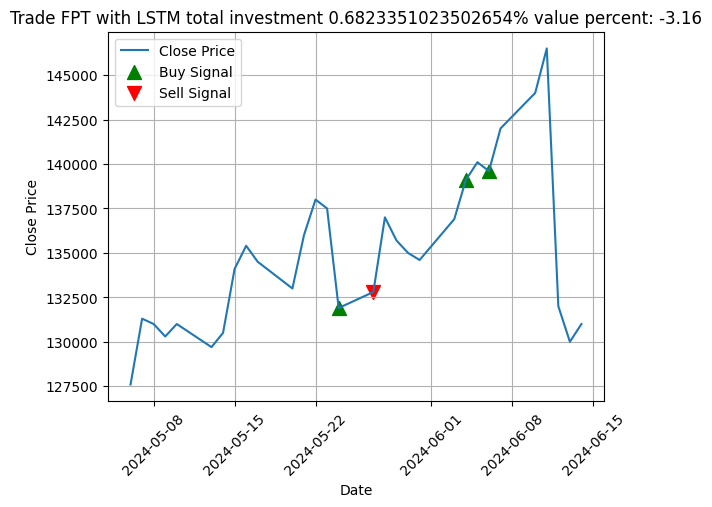

0.6823351023502654
-3.16


In [96]:
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'Trade {symbol} total investment {last_total_investment}%, value percent {investmentvalue}% Gain {total_gain} Gain percent: {investGain}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()